"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [157]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt

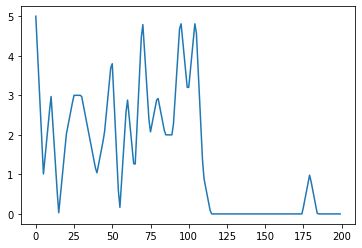

In [158]:
data_vec = np.array([5, 1, 3, 0, 2, 3, 3, 2, 1, 2, 4, 0, 3, 1, 5, 2, 3, 2, 2, 5, 3, 5,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
data_vec = np.interp(np.linspace(0,40,200),np.arange(len(data_vec)),data_vec)
idx = np.arange(len(data_vec))
plt.plot(data_vec)

In [159]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_vec,2,axis=-1)])
print(mean_vals)

[2.41306533 0.42286432]


In [160]:
def var_sig_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-b*x))

def var_sig_exp_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-np.exp(b)*x))


In [161]:
def var_sig_exp_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-tt.exp(b)*x))

def var_sig_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-b*x))

In [181]:


selected_sig = var_sig_tt

with pm.Model() as model:
    #sig_b = pm.Normal('sig_b', 5,10)
    sig_b = pm.HalfCauchy('sig_b', 1)
    
    lambda_latent = [0,1]
    #     pm.Exponential('lambda_latent', 
    #                                     1/(np.mean(mean_vals)), 
    #                                     shape = 2,
    #                                   testval = mean_vals + 1e-3)    
    
    tau_latent = pm.Beta('tau_latent', 2, 5, testval = 0.5)
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    lambda_ =  pm.Deterministic('lambda_',
                                (1 - selected_sig(idx-tau,sig_b))*lambda_latent[0] + \
                                selected_sig(idx-tau,sig_b)*lambda_latent[1])
    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=data_vec)

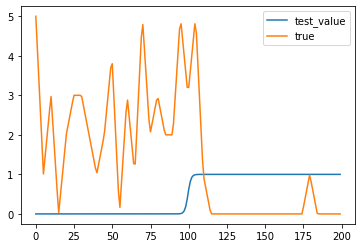

In [182]:
plt.plot(lambda_.tag.test_value,label='test_value')
plt.plot(data_vec,label='true')
plt.legend()

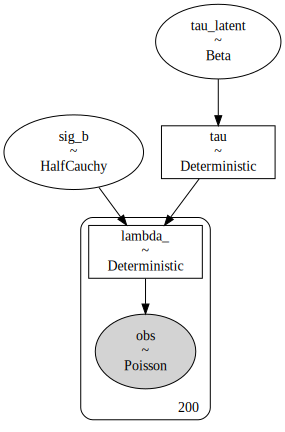

In [183]:
pm.model_to_graphviz(model)

In [166]:
with model:
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=0)

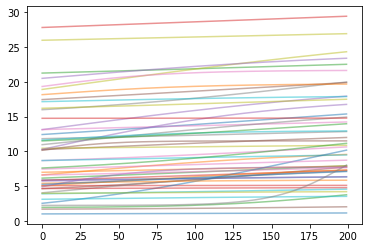

In [167]:
plt.plot(prior_checks['lambda_'].T, alpha = 0.5);

In [168]:
with model:
    inference = pm.ADVI('full-rank')
    tracker = pm.callbacks.Tracker(
            mean=inference.approx.mean.eval,  # callable that returns mean
            std=inference.approx.std.eval,  # callable that returns std
        )
    approx = pm.fit(n=10000, method=inference,
                   callbacks=[tracker])
    trace = approx.sample(draws=2000)

Finished [100%]: Average Loss = 332.98


In [169]:
def tracker_names_out(model):
    raw_rvs = model.free_RVs
    names = [x.name for x in raw_rvs]
    sizes = [x.tag.test_value.shape for x in raw_rvs]
    fin_sizes = [x[0] if x is not () else 1 for x in sizes]
    fin_names = [[this_name]*this_size for this_name, this_size in zip(names,fin_sizes)]
    fin_names = [x for y in fin_names for x in y]
    return fin_names

In [170]:
rv_names = tracker_names_out(model)
rv_names

['a_tau_log__',
 'b_tau_log__',
 'tau_latent_logodds__',
 'min_val_log__',
 'scale_log__',
 'mu_sig',
 'sig_b']

In [171]:
tracker_mean = np.stack(tracker['mean'])
tracker_std = np.stack(tracker['std'])

In [172]:
x = np.linspace(-3,3)
outs = np.stack([var_sig_exp_np(x,b) for b in np.exp(tracker_mean[:,0])])

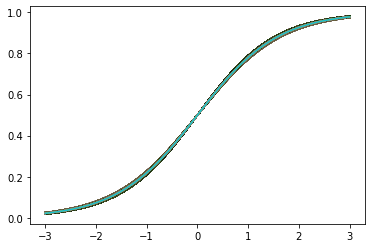

In [173]:
plt.plot(x,outs.T);

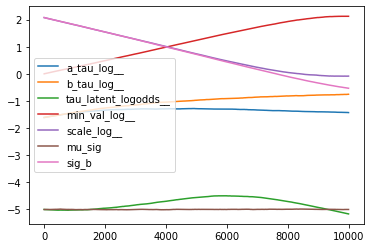

In [174]:
lineObjects = plt.plot(tracker_mean)
plt.legend(iter(lineObjects), rv_names)

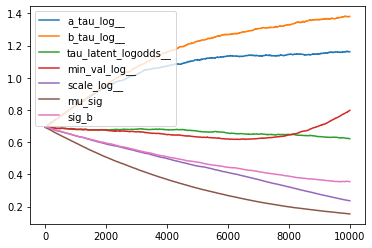

In [175]:
lineObjects = plt.plot(tracker_std)
plt.legend(iter(lineObjects), rv_names)

-5.141479729122797

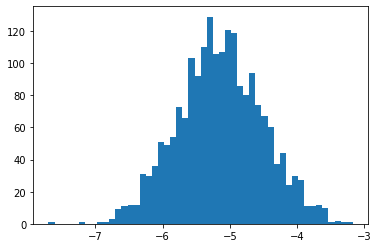

In [176]:
plt.hist(trace['sig_b'],50);
np.mean(trace['sig_b'])

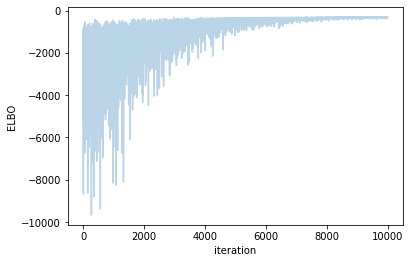

In [177]:
plt.plot(-approx.hist, alpha=.3)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [178]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

In [179]:
tau = trace['tau']

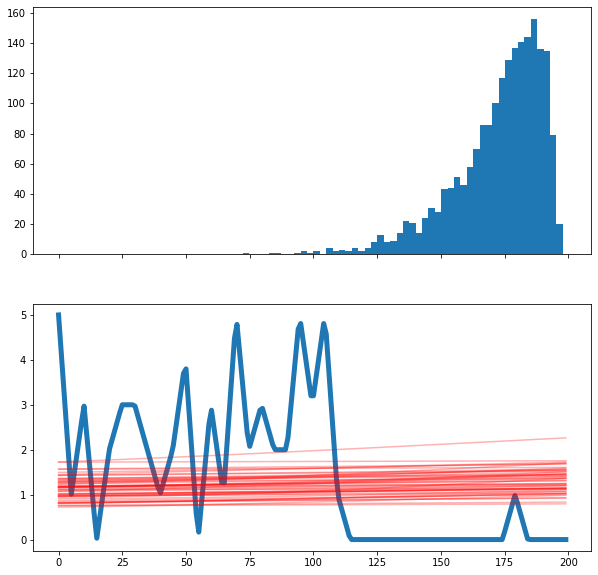

In [180]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].hist(tau,50)
ax[1].plot(data_vec, linewidth = 5)
ax[1].plot(trace['lambda_'][:50].T,color='red', alpha = 0.3);
